In [1]:
import argparse
import cv2
import sys
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from dataclasses import dataclass


def remove_small_components(binary_image, k = 7):
    """
    Remove connected components smaller than a given size.

    Args:
        binary_image (numpy.ndarray): Binary image (1 for foreground, 0 for background).
        k (int): Minimum size of connected components to retain.

    Returns:
        numpy.ndarray: Binary image with small components removed.
    """
    # Label connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    
    # Create an output image initialized to 0
    output_image = np.zeros_like(binary_image, dtype=np.uint8)
    
    # Iterate over each component
    for i in range(1, num_labels):  # Skip the background label (0)
        if stats[i, cv2.CC_STAT_AREA] >= k:
            # Retain components larger than or equal to k
            output_image[labels == i] = 1
    
    return output_image


@dataclass
class Component:
    """Class to store connected component information"""
    bbox: Tuple[int, int, int, int]  # x, y, w, h
    centroid: Tuple[float, float]
    area: int

class Docstrum:
    def __init__(self, k_nearest: int = 5, angle_threshold: float = 30):
        """
        Initialize docstrum processor
        
        Args:
            k_nearest: Number of nearest neighbors to find (default 5)
            angle_threshold: Angle threshold in degrees for within-line connections
        """
        self.k = k_nearest
        self.angle_threshold = angle_threshold

    def preprocess(self, image: np.ndarray) -> np.ndarray:
        """
        Preprocess the image - noise reduction and binarization
        
        Args:
            image: Input grayscale image
            
        Returns:
            Binary image
        """
        # Apply Otsu's thresholding
        _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Apply morphological operations to remove noise
        # kernel = np.ones((3,3), np.uint8)
        # binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        # binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        binary = (binary == 0).astype(np.uint8)

        binary = remove_small_components(binary, k=7)
        
        return binary

    def find_connected_components(self, binary: np.ndarray) -> List[Component]:
        """
        Find connected components in binary image and filter them based on size
        
        Args:
            binary: Binary image
            
        Returns:
            List of Component objects
        """
        # Invert binary image if needed (assuming text is black)
        if np.mean(binary) > 127:
            binary = cv2.bitwise_not(binary)
            
        # Find connected components
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)
        
        if num_labels < 2:  # 1 is background
            raise ValueError("No components found in the image")
        
        # Calculate median area to use for filtering
        areas = stats[1:, cv2.CC_STAT_AREA]  # Skip background
        median_area = np.median(areas)
        
        components = []
        # Skip background component (index 0)
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            
            # Filter out components that are too small or too large
            if area < median_area * 0.05 or area > median_area * 20:
                continue
                
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            
            components.append(Component(
                bbox=(x, y, w, h),
                centroid=(centroids[i][0], centroids[i][1]),
                area=area
            ))
        
        if not components:
            raise ValueError("No valid components found after filtering")
            
        print(f"Found {len(components)} valid components")
        return components

    def find_nearest_neighbors(self, components: List[Component]) -> List[List[Tuple[int, float, float]]]:
        """
        Find k nearest neighbors for each component
        
        Args:
            components: List of components
            
        Returns:
            List of lists containing (neighbor_idx, distance, angle) tuples for each component
        """
        if len(components) < self.k + 1:
            raise ValueError(f"Not enough components ({len(components)}) for k={self.k} nearest neighbors")
            
        # Extract centroids
        points = np.array([c.centroid for c in components])
        
        # Adjust k if necessary
        k = min(self.k + 1, len(components))
        print(f"Finding {k-1} nearest neighbors for each component")
        
        # Build KD-tree for efficient nearest neighbor search
        tree = KDTree(points)
        
        # Find k nearest neighbors (first one is the point itself)
        distances, indices = tree.query(points, k=k)
        
        neighbors_info = []
        for i, (component_neighbors, neighbor_distances) in enumerate(zip(indices, distances)):
            # Skip the first neighbor (point itself)
            neighbors = []
            for j, (neighbor_idx, dist) in enumerate(zip(component_neighbors[1:], neighbor_distances[1:]), 1):
                # Calculate angle between components
                dx = points[neighbor_idx][0] - points[i][0]
                dy = points[neighbor_idx][1] - points[i][1]
                angle = np.degrees(np.arctan2(dy, dx)) % 180
                
                neighbors.append((neighbor_idx, dist, angle))
            
            neighbors_info.append(neighbors)
            
        return neighbors_info

    # def find_nearest_neighbors(self, components: List[Component], spacing_factor: float = 2.) -> List[List[Tuple[int, float, float]]]:
    #     """
    #     Find k nearest neighbors for each component, filtering out those that are too far apart
    #     based on local inter-character spacing.
        
    #     Args:
    #         components: List of components
    #         spacing_factor: Factor to multiply with inter-character space for max distance threshold
            
    #     Returns:
    #         List of lists containing (neighbor_idx, distance, angle) tuples for each component
    #     """
    #     if len(components) < self.k + 1:
    #         raise ValueError(f"Not enough components ({len(components)}) for k={self.k} nearest neighbors")
            
    #     # Extract centroids and widths
    #     points = np.array([c.centroid for c in components])
    #     widths = np.array([c.bbox[2] for c in components])
        
    #     # Adjust k to get more candidates initially (we'll filter some out)
    #     initial_k = min(self.k * 2 + 1, len(components))
    #     print(f"Finding {initial_k-1} initial nearest neighbors for each component")
        
    #     # Build KD-tree for efficient nearest neighbor search
    #     tree = KDTree(points)
        
    #     # Find initial k nearest neighbors (first one is the point itself)
    #     distances, indices = tree.query(points, k=initial_k)
        
    #     neighbors_info = []
    #     for i, (component_neighbors, neighbor_distances) in enumerate(zip(indices, distances)):
    #         # Calculate local inter-character space based on nearest components
    #         # Use median width of current component and its closest neighbors
    #         local_widths = widths[component_neighbors[:min(5, len(component_neighbors))]]
    #         median_width = np.median(local_widths)
    #         max_distance = median_width * spacing_factor
            
    #         # Filter and process neighbors
    #         neighbors = []
    #         for j, (neighbor_idx, dist) in enumerate(zip(component_neighbors[1:], neighbor_distances[1:]), 1):
    #             # Skip if distance exceeds threshold
    #             if dist > max_distance:
    #                 continue
                    
    #             # Calculate angle between components
    #             dx = points[neighbor_idx][0] - points[i][0]
    #             dy = points[neighbor_idx][1] - points[i][1]
    #             angle = np.degrees(np.arctan2(dy, dx)) % 180
                
    #             neighbors.append((neighbor_idx, dist, angle))
                
    #             # Break if we have enough valid neighbors
    #             if len(neighbors) >= self.k:
    #                 break
            
    #         neighbors_info.append(neighbors)
            
    #     return neighbors_info


    def estimate_orientation(self, neighbors_info: List[List[Tuple[int, float, float]]]) -> float:
        """
        Estimate document orientation from neighbor angles
        
        Args:
            neighbors_info: List of neighbor information
            
        Returns:
            Estimated orientation angle in degrees
        """
        # Collect all angles
        angles = []
        for component_neighbors in neighbors_info:
            angles.extend([n[2] for n in component_neighbors])
            
        # Create histogram of angles
        hist, bins = np.histogram(angles, bins=180, range=(0, 180))
        
        # Apply smoothing to histogram
        hist = np.convolve(hist, np.ones(5)/5, mode='same')
        
        # Find peak
        orientation = bins[np.argmax(hist)]
        
        return orientation

    # def find_text_lines(self, components: List[Component], 
    #                    neighbors_info: List[List[Tuple[int, float, float]]], 
    #                    orientation: float) -> List[List[int]]:
    #     """
    #     Group components into text lines
        
    #     Args:
    #         components: List of components
    #         neighbors_info: List of neighbor information
    #         orientation: Estimated text orientation
            
    #     Returns:
    #         List of text lines, where each line is a list of component indices
    #     """
    #     # Create graph of connected components
    #     graph = {i: [] for i in range(len(components))}
        
    #     for i, component_neighbors in enumerate(neighbors_info):
    #         for neighbor_idx, dist, angle in component_neighbors:
    #             # Check if angle is within threshold of orientation
    #             angle_diff = min((angle - orientation) % 180, (orientation - angle) % 180)
    #             if angle_diff < self.angle_threshold:
    #                 graph[i].append(neighbor_idx)
    #                 graph[neighbor_idx].append(i)
        
    #     # Find connected components in graph (text lines)
    #     text_lines = []
    #     visited = set()
        
    #     def dfs(node: int, current_line: List[int]):
    #         visited.add(node)
    #         current_line.append(node)
    #         for neighbor in graph[node]:
    #             if neighbor not in visited:
    #                 dfs(neighbor, current_line)
        
    #     for i in range(len(components)):
    #         if i not in visited:
    #             current_line = []
    #             dfs(i, current_line)
    #             # Sort components in line by x-coordinate for left-to-right reading
    #             current_line.sort(key=lambda idx: components[idx].centroid[0])
    #             text_lines.append(current_line)
        
    #     # Sort text lines by y-coordinate (top to bottom)
    #     text_lines.sort(key=lambda line: min(components[idx].centroid[1] for idx in line))
        
    #     return text_lines

    def find_text_lines(self, components: List[Component], 
                    neighbors_info: List[List[Tuple[int, float, float]]], 
                    orientation: float,
                    spacing_factor: float = 1.2) -> List[List[int]]:
        """
        Group components into text lines, considering local intercharacter spacing
        
        Args:
            components: List of components
            neighbors_info: List of neighbor information
            orientation: Estimated text orientation
            spacing_factor: Factor to multiply local intercharacter space for max allowed gap
                
        Returns:
            List of text lines, where each line is a list of component indices
        """
        def calculate_local_spacing(component_idx: int, potential_neighbors: List[int]) -> float:
            """Calculate median intercharacter spacing for a component and its aligned neighbors"""
            if not potential_neighbors:
                return float('inf')
                
            # Get horizontal gaps between component and its aligned neighbors
            gaps = []
            comp = components[component_idx]
            
            for n_idx in potential_neighbors:
                neighbor = components[n_idx]
                
                # Determine which component is leftmost
                if comp.centroid[0] < neighbor.centroid[0]:
                    left, right = comp, neighbor
                    left_idx, right_idx = component_idx, n_idx
                else:
                    left, right = neighbor, comp
                    left_idx, right_idx = n_idx, component_idx
                    
                # Calculate gap between components
                gap = (right.bbox[0] - (left.bbox[0] + left.bbox[2]))
                if gap > 0:  # Only consider positive gaps
                    gaps.append(gap)
                    
            return np.median(gaps) if gaps else float('inf')
        
        # Create graph of connected components
        graph = {i: [] for i in range(len(components))}
        
        # First pass: Find potentially aligned components
        aligned_components = {i: [] for i in range(len(components))}
        for i, component_neighbors in enumerate(neighbors_info):
            for neighbor_idx, dist, angle in component_neighbors:
                # Check if angle is within threshold of orientation
                angle_diff = min((angle - orientation) % 180, (orientation - angle) % 180)
                if angle_diff < self.angle_threshold:
                    aligned_components[i].append(neighbor_idx)
                    aligned_components[neighbor_idx].append(i)
        
        # Second pass: Apply local spacing constraints
        for i in range(len(components)):
            # Calculate local spacing for current component
            local_spacing = calculate_local_spacing(i, aligned_components[i])
            
            # Add edges only if components are within local spacing constraint
            for neighbor_idx in aligned_components[i]:
                comp = components[i]
                neighbor = components[neighbor_idx]
                
                # Calculate horizontal distance between components
                if comp.centroid[0] < neighbor.centroid[0]:
                    left, right = comp, neighbor
                else:
                    left, right = neighbor, comp
                    
                distance = right.bbox[0] - (left.bbox[0] + left.bbox[2])
                
                # Only add edge if distance is within local spacing constraint
                if distance <= local_spacing * spacing_factor:
                    graph[i].append(neighbor_idx)
                    graph[neighbor_idx].append(i)
        
        # Find connected components in graph (text lines)
        text_lines = []
        visited = set()
        
        def dfs(node: int, current_line: List[int]):
            visited.add(node)
            current_line.append(node)
            for neighbor in graph[node]:
                if neighbor not in visited:
                    dfs(neighbor, current_line)
        
        for i in range(len(components)):
            if i not in visited:
                current_line = []
                dfs(i, current_line)
                # Sort components in line by x-coordinate for left-to-right reading
                current_line.sort(key=lambda idx: components[idx].centroid[0])
                text_lines.append(current_line)
        
        # Sort text lines by y-coordinate (top to bottom)
        text_lines.sort(key=lambda line: min(components[idx].centroid[1] for idx in line))
        
        return text_lines
        
    def find_blocks(self, components: List[Component], text_lines: List[List[int]], 
                   max_vertical_gap: float = 2.5) -> List[List[List[int]]]:
        """
        Group text lines into blocks based on vertical spacing
        
        Args:
            components: List of components
            text_lines: List of text lines
            max_vertical_gap: Maximum allowed vertical gap between lines in a block,
                            as a factor of median line spacing
            
        Returns:
            List of blocks, where each block is a list of text lines
        """
        if not text_lines:
            return []
            
        # Calculate median line spacing
        line_spacings = []
        for i in range(len(text_lines) - 1):
            current_line_bottom = max(components[idx].bbox[1] + components[idx].bbox[3] 
                                    for idx in text_lines[i])
            next_line_top = min(components[idx].bbox[1] 
                              for idx in text_lines[i + 1])
            line_spacings.append(next_line_top - current_line_bottom)
            
        if not line_spacings:
            return [text_lines]  # Single block with all lines
            
        median_spacing = np.median(line_spacings) *1.2
        
        # Group lines into blocks
        blocks = []
        current_block = [text_lines[0]]
        
        for i in range(1, len(text_lines)):
            current_line = text_lines[i]
            prev_line = text_lines[i - 1]
            
            # Calculate vertical gap between lines
            prev_line_bottom = max(components[idx].bbox[1] + components[idx].bbox[3] 
                                 for idx in prev_line)
            current_line_top = min(components[idx].bbox[1] 
                                 for idx in current_line)
            gap = current_line_top - prev_line_bottom
            
            if gap > median_spacing * max_vertical_gap:
                # Start new block
                blocks.append(current_block)
                current_block = [current_line]
            else:
                # Add to current block
                current_block.append(current_line)
        
        # Add last block
        blocks.append(current_block)
        
        return blocks

    def process(self, image: np.ndarray, visualize: bool = True) -> Tuple[List[Component], List[List[int]], float]:
        """
        Main processing function with visualization
        
        Args:
            image: Input grayscale image
            visualize: Whether to show visualization plots
            
        Returns:
            Tuple containing:
            - List of components
            - List of text lines
            - Estimated orientation
        """
        # Preprocess image
        binary = self.preprocess(image)
        if visualize:
            visualize_preprocessing(image, binary)
        
        # Find connected components
        components = self.find_connected_components(binary)
        if visualize:
            visualize_components(image, components)
        
        # Find nearest neighbors
        neighbors_info = self.find_nearest_neighbors(components)
        if visualize:
            visualize_neighbors(image, components, neighbors_info)
        
        # Estimate orientation
        orientation = self.estimate_orientation(neighbors_info)
        if visualize:
            visualize_orientation_histogram(neighbors_info, orientation)
        
        # Find text lines
        text_lines = self.find_text_lines(components, neighbors_info, orientation)
        if visualize:
            visualize_text_lines(image, components, text_lines)
        
        # Find initial blocks
        initial_blocks = self.find_blocks(components, text_lines)
        if visualize:
            visualize_initial_blocks(image, components, initial_blocks)
        
        # Merge blocks
        merged_blocks = self.merge_overlapping_blocks(components, initial_blocks)
        if visualize:
            visualize_merged_blocks(image, components, merged_blocks, orientation)
        
        return components, text_lines, orientation
    # def merge_overlapping_blocks(self, components: List[Component], blocks: List[List[List[int]]], 
    #                         overlap_threshold: float = 0.3) -> List[List[List[int]]]:
    #     """
    #     Merge blocks that overlap significantly
        
    #     Args:
    #         components: List of components
    #         blocks: List of blocks (each block is a list of text lines)
    #         overlap_threshold: Minimum overlap ratio to merge blocks (0 to 1)
            
    #     Returns:
    #         List of merged blocks
    #     """
    #     def get_block_bounds(block):
    #         # Get all component indices in the block
    #         block_components = [comp_idx for line in block for comp_idx in line]
    #         if not block_components:
    #             return None
                
    #         # Find block boundaries
    #         min_x = min(components[idx].bbox[0] for idx in block_components)
    #         min_y = min(components[idx].bbox[1] for idx in block_components)
    #         max_x = max(components[idx].bbox[0] + components[idx].bbox[2] 
    #                 for idx in block_components)
    #         max_y = max(components[idx].bbox[1] + components[idx].bbox[3] 
    #                 for idx in block_components)
            
    #         return (min_x, min_y, max_x, max_y)
        
    #     def compute_overlap(bounds1, bounds2):
    #         if not bounds1 or not bounds2:
    #             return 0
                
    #         x1, y1, x2, y2 = bounds1
    #         x3, y3, x4, y4 = bounds2
            
    #         # Calculate intersection
    #         x_left = max(x1, x3)
    #         y_top = max(y1, y3)
    #         x_right = min(x2, x4)
    #         y_bottom = min(y2, y4)
            
    #         if x_right < x_left or y_bottom < y_top:
    #             return 0
                
    #         intersection = (x_right - x_left) * (y_bottom - y_top)
            
    #         # Calculate areas
    #         area1 = (x2 - x1) * (y2 - y1)
    #         area2 = (x4 - x3) * (y4 - y3)
            
    #         # Return overlap ratio (intersection over minimum area)
    #         return intersection / min(area1, area2)
        
    #     # Continue merging until no more merges are possible
    #     while True:
    #         merged = False
            
    #         # Get bounds for all blocks
    #         block_bounds = [get_block_bounds(block) for block in blocks]
            
    #         # Check each pair of blocks
    #         for i in range(len(blocks)):
    #             if i >= len(blocks):  # Check if block was removed
    #                 continue
                    
    #             for j in range(i + 1, len(blocks)):
    #                 if j >= len(blocks):  # Check if block was removed
    #                     continue
                        
    #                 # Compute overlap between blocks
    #                 overlap = compute_overlap(block_bounds[i], block_bounds[j])
                    
    #                 if overlap > overlap_threshold:
    #                     # Merge blocks
    #                     blocks[i].extend(blocks[j])
    #                     # Sort lines in merged block by y-coordinate
    #                     blocks[i].sort(key=lambda line: min(components[idx].centroid[1] 
    #                                                     for idx in line))
    #                     # Remove merged block
    #                     blocks.pop(j)
    #                     block_bounds.pop(j)
    #                     merged = True
    #                     break
                
    #             if merged:
    #                 break
                    
    #         if not merged:
    #             break
        
    #     return blocks


    def merge_overlapping_blocks(self, components: List[Component], blocks: List[List[List[int]]], 
                                overlap_threshold: float = 0.3,
                                alignment_threshold: float = 0.25,
                                corner_threshold: float = 15) -> List[List[List[int]]]:
        """
        Merge blocks that:
        1. Overlap horizontally or vertically with similar alignments
        2. One block is contained within another
        3. Share approximately similar borders (via corner proximity)
        
        Args:
            components: List of components
            blocks: List of blocks (each block is a list of text lines)
            overlap_threshold: Minimum overlap ratio to merge blocks (0 to 1)
            alignment_threshold: Maximum allowed difference in alignment relative to block size
            corner_threshold: Maximum distance between corners to consider them as sharing a border
            
        Returns:
            List of merged blocks
        """
        def get_block_bounds(block):
            # Get all component indices in the block
            block_components = [comp_idx for line in block for comp_idx in line]
            if not block_components:
                return None
                
            # Find block boundaries
            min_x = min(components[idx].bbox[0] for idx in block_components)
            min_y = min(components[idx].bbox[1] for idx in block_components)
            max_x = max(components[idx].bbox[0] + components[idx].bbox[2] 
                    for idx in block_components)
            max_y = max(components[idx].bbox[1] + components[idx].bbox[3] 
                    for idx in block_components)
            
            return (min_x, min_y, max_x, max_y)
        
        def compute_horizontal_overlap(bounds1, bounds2):
            if not bounds1 or not bounds2:
                return 0
                
            x1, _, x2, _ = bounds1
            x3, _, x4, _ = bounds2
            
            # Calculate horizontal intersection
            overlap = max(0, min(x2, x4) - max(x1, x3))
            
            # Calculate widths
            width1 = x2 - x1
            width2 = x4 - x3
            
            # Return overlap ratio
            return overlap / min(width1, width2)
        
        def compute_vertical_overlap(bounds1, bounds2):
            if not bounds1 or not bounds2:
                return 0
                
            _, y1, _, y2 = bounds1
            _, y3, _, y4 = bounds2
            
            # Calculate vertical intersection
            overlap = max(0, min(y2, y4) - max(y1, y3))
            
            # Calculate heights
            height1 = y2 - y1
            height2 = y4 - y3
            
            # Return overlap ratio
            return overlap / min(height1, height2)
        
        def check_horizontal_alignment(bounds1, bounds2):
            _, y1, _, y2 = bounds1
            _, y3, _, y4 = bounds2
            
            height1 = y2 - y1
            height2 = y4 - y3
            
            # Check if vertical positions are similar relative to block heights
            y_diff = abs((y1 + y2)/2 - (y3 + y4)/2)
            return y_diff <= alignment_threshold * max(height1, height2)
        
        def check_vertical_alignment(bounds1, bounds2):
            x1, _, x2, _ = bounds1
            x3, _, x4, _ = bounds2
            
            width1 = x2 - x1
            width2 = x4 - x3
            
            # Check if horizontal positions are similar relative to block widths
            x_diff = abs((x1 + x2)/2 - (x3 + x4)/2)
            return x_diff <= alignment_threshold * max(width1, width2)

        def check_containment(bounds1, bounds2):
            """Check if either block is contained within the other"""
            if not bounds1 or not bounds2:
                return False
                
            x1, y1, x2, y2 = bounds1
            x3, y3, x4, y4 = bounds2
            
            # Check if bounds1 is contained in bounds2
            contained_in_2 = (x3 <= x1 and x2 <= x4 and 
                            y3 <= y1 and y2 <= y4)
            
            # Check if bounds2 is contained in bounds1
            contained_in_1 = (x1 <= x3 and x4 <= x2 and 
                            y1 <= y3 and y4 <= y2)
            
            return contained_in_1 or contained_in_2

        def check_shared_border(bounds1, bounds2):
            """Check if blocks share approximately similar borders (via corner proximity)"""
            if not bounds1 or not bounds2:
                return False
                
            x1, y1, x2, y2 = bounds1
            x3, y3, x4, y4 = bounds2
            
            # Get corners for both blocks
            corners1 = [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]
            corners2 = [(x3, y3), (x3, y4), (x4, y3), (x4, y4)]
            
            # Count how many corners are close to each other
            close_corners = 0
            for c1 in corners1:
                for c2 in corners2:
                    distance = np.sqrt((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2)
                    if distance <= corner_threshold:
                        close_corners += 1
                        
            # Return True if at least 2 corners are close (indicating shared border)
            return close_corners >= 2
        
        # Continue merging until no more merges are possible
        while True:
            merged = False
            
            # Get bounds for all blocks
            block_bounds = [get_block_bounds(block) for block in blocks]
            
            # Check each pair of blocks
            for i in range(len(blocks)):
                if i >= len(blocks):  # Check if block was removed
                    continue
                    
                for j in range(i + 1, len(blocks)):
                    if j >= len(blocks):  # Check if block was removed
                        continue
                        
                    bounds1 = block_bounds[i]
                    bounds2 = block_bounds[j]
                    
                    # Check all merge conditions
                    h_overlap = compute_horizontal_overlap(bounds1, bounds2)
                    h_aligned = check_horizontal_alignment(bounds1, bounds2)
                    v_overlap = compute_vertical_overlap(bounds1, bounds2)
                    v_aligned = check_vertical_alignment(bounds1, bounds2)
                    is_contained = check_containment(bounds1, bounds2)
                    shares_border = check_shared_border(bounds1, bounds2)
                    
                    # Merge if any of the conditions are met
                    if ((h_overlap > overlap_threshold and h_aligned) or 
                        (v_overlap > overlap_threshold and v_aligned) or
                        is_contained or shares_border):
                        # Merge blocks
                        blocks[i].extend(blocks[j])
                        # Sort lines in merged block by y-coordinate
                        blocks[i].sort(key=lambda line: min(components[idx].centroid[1] 
                                                        for idx in line))
                        # Remove merged block
                        blocks.pop(j)
                        block_bounds.pop(j)
                        merged = True
                        break
                
                if merged:
                    break
                    
            if not merged:
                break
        
        return blocks

    def find_blocks(self, components: List[Component], text_lines: List[List[int]], 
                max_vertical_gap: float = 1.5, horizontal_overlap_threshold: float = 0.5) -> List[List[List[int]]]:
        """
        Improved block detection with stricter merging criteria
        
        Args:
            components: List of components
            text_lines: List of text lines
            max_vertical_gap: Maximum vertical gap multiplier (smaller = stricter)
            horizontal_overlap_threshold: Required horizontal overlap ratio (larger = stricter)
        """
        if not text_lines:
            return []
            
        def get_line_bounds(line):
            x1 = min(components[idx].bbox[0] for idx in line)
            y1 = min(components[idx].bbox[1] for idx in line)
            x2 = max(components[idx].bbox[0] + components[idx].bbox[2] for idx in line)
            y2 = max(components[idx].bbox[1] + components[idx].bbox[3] for idx in line)
            return (x1, y1, x2, y2)

        def get_line_height(line):
            heights = [components[idx].bbox[3] for idx in line]
            return np.median(heights)
        
        def horizontal_overlap_ratio(bounds1, bounds2):
            x1, _, x2, _ = bounds1
            x3, _, x4, _ = bounds2
            overlap = min(x2, x4) - max(x1, x3)
            if overlap <= 0:
                return 0
            width1 = x2 - x1
            width2 = x4 - x3
            return overlap / min(width1, width2)
        
        # Calculate typical line spacing
        line_spacings = []
        line_bounds = [get_line_bounds(line) for line in text_lines]
        line_heights = [get_line_height(line) for line in text_lines]
        
        for i in range(len(text_lines) - 1):
            _, _, _, y2 = line_bounds[i]
            _, y3, _, _ = line_bounds[i + 1]
            line_spacings.append(y3 - y2)
        
        if not line_spacings:
            return [text_lines]
            
        median_spacing = np.median(line_spacings)
        median_height = np.median(line_heights)
        
        # Group lines into initial blocks
        blocks = []
        current_block = [text_lines[0]]
        current_bounds = line_bounds[0]
        
        for i in range(1, len(text_lines)):
            current_line = text_lines[i]
            current_line_bounds = line_bounds[i]
            
            # Check vertical gap
            _, _, _, prev_bottom = current_bounds
            _, curr_top, _, _ = current_line_bounds
            vertical_gap = curr_top - prev_bottom
            
            # Check horizontal overlap with previous line
            overlap = horizontal_overlap_ratio(current_bounds, current_line_bounds)
            
            # Stricter merging conditions:
            # 1. Must have significant horizontal overlap
            # 2. Vertical gap must be reasonable
            # 3. Consider line height in spacing calculation
            if (overlap > horizontal_overlap_threshold and 
                vertical_gap <= max(median_spacing * max_vertical_gap, median_height * 1.5)):
                current_block.append(current_line)
                # Update bounds
                x1 = min(current_bounds[0], current_line_bounds[0])
                y1 = min(current_bounds[1], current_line_bounds[1])
                x2 = max(current_bounds[2], current_line_bounds[2])
                y2 = max(current_bounds[3], current_line_bounds[3])
                current_bounds = (x1, y1, x2, y2)
            else:
                blocks.append(current_block)
                current_block = [current_line]
                current_bounds = current_line_bounds
        
        blocks.append(current_block)
        return blocks

    def visualize_results(self, image: np.ndarray, components: List[Component], 
                        text_lines: List[List[int]], orientation: float):
        """
        Visualize results with both initial and merged blocks
        """
        # Create RGB visualization image
        vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
        
        # Find initial blocks
        initial_blocks = self.find_blocks(components, text_lines)
        print(f"Found {len(initial_blocks)} initial blocks")
        
        # Merge blocks based on corner proximity
        merged_blocks = self.merge_overlapping_blocks(components, initial_blocks)
        print(f"After merging: {len(merged_blocks)} blocks")
        
        # Generate distinct colors for blocks (avoiding similar colors)
        colors = plt.cm.Set3(np.linspace(0, 1, len(merged_blocks)))
        colors = (colors[:, :3] * 255).astype(int)
        
        # Draw merged blocks
        for block_idx, block in enumerate(merged_blocks):
            # Get all components in block
            block_components = [comp_idx for line in block for comp_idx in line]
            
            if not block_components:
                continue
                
            # Find block boundaries
            min_x = min(components[idx].bbox[0] for idx in block_components)
            min_y = min(components[idx].bbox[1] for idx in block_components)
            max_x = max(components[idx].bbox[0] + components[idx].bbox[2] 
                    for idx in block_components)
            max_y = max(components[idx].bbox[1] + components[idx].bbox[3] 
                    for idx in block_components)
            
            # Draw block rectangle with padding
            color = colors[block_idx % len(colors)].tolist()
            padding = 3
            cv2.rectangle(vis_image, 
                        (min_x - padding, min_y - padding), 
                        (max_x + padding, max_y + padding), 
                        color, 2)
        
        plt.figure(figsize=(15, 10))
        plt.imshow(vis_image)
        plt.title(f'Detected Text Blocks (Orientation: {orientation:.1f}°)')
        plt.axis('off')
        plt.show()

        






In [2]:
def visualize_preprocessing(image: np.ndarray, binary: np.ndarray):
    """
    Visualize the preprocessing step showing original and binary images side by side
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Show original image
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Show binary image
    ax2.imshow(binary, cmap='gray')
    ax2.set_title('Preprocessed Binary Image')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_components(image: np.ndarray, components: List[Component]):
    """
    Visualize detected connected components with bounding boxes and centroids
    """
    # Create RGB visualization image
    vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    # Generate distinct colors
    colors = plt.cm.rainbow(np.linspace(0, 1, len(components)))
    colors = (colors[:, :3] * 255).astype(int)
    
    # Draw components
    for idx, comp in enumerate(components):
        color = colors[idx % len(colors)].tolist()
        x, y, w, h = comp.bbox
        
        # Draw bounding box
        cv2.rectangle(vis_image, (x, y), (x + w, y + h), color, 1)
        
        # Draw centroid
        cx, cy = map(int, comp.centroid)
        cv2.circle(vis_image, (cx, cy), 2, color, -1)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(vis_image)
    plt.title(f'Detected Components (Total: {len(components)})')
    plt.axis('off')
    plt.show()

def visualize_neighbors(image: np.ndarray, components: List[Component], 
                    neighbors_info: List[List[Tuple[int, float, float]]]):
    """
    Visualize k-nearest neighbors connections between components
    """
    # Create RGB visualization image
    vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    # Draw connections between components
    for i, component_neighbors in enumerate(neighbors_info):
        x1, y1 = map(int, components[i].centroid)
        
        for neighbor_idx, dist, angle in component_neighbors:
            x2, y2 = map(int, components[neighbor_idx].centroid)
            
            # Color based on angle (cyclic color map)
            color = plt.cm.hsv(angle / 180)[:3]
            color = tuple(int(c * 255) for c in color)
            
            # Draw line connecting components
            cv2.line(vis_image, (x1, y1), (x2, y2), color, 1, cv2.LINE_AA)
    
    # Draw component centroids on top
    for comp in components:
        cx, cy = map(int, comp.centroid)
        cv2.circle(vis_image, (cx, cy), 2, (255, 0, 0), -1)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(vis_image)
    plt.title('K-Nearest Neighbors Connections')
    plt.axis('off')
    plt.show()

def visualize_orientation_histogram(neighbors_info: List[List[Tuple[int, float, float]]], 
                                orientation: float):
    """
    Visualize histogram of angles and detected orientation
    """
    # Collect all angles
    angles = []
    for component_neighbors in neighbors_info:
        angles.extend([n[2] for n in component_neighbors])
        
    # Create histogram
    plt.figure(figsize=(12, 6))
    hist, bins, _ = plt.hist(angles, bins=180, range=(0, 180), 
                            color='skyblue', alpha=0.7)
    
    # Apply smoothing for visualization
    smoothed = np.convolve(hist, np.ones(5)/5, mode='same')
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, smoothed, 'r-', linewidth=2, label='Smoothed')
    
    # Mark detected orientation
    plt.axvline(x=orientation, color='green', linestyle='--', 
                label=f'Detected Orientation: {orientation:.1f}°')
    
    plt.title('Histogram of Neighbor Angles')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def visualize_text_lines(image: np.ndarray, components: List[Component], 
                        text_lines: List[List[int]]):
    """
    Visualize detected text lines with different colors
    """
    # Create RGB visualization image
    vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    # Generate distinct colors for lines
    colors = plt.cm.rainbow(np.linspace(0, 1, len(text_lines)))
    colors = (colors[:, :3] * 255).astype(int)
    
    # Draw text lines
    for line_idx, line in enumerate(text_lines):
        color = colors[line_idx % len(colors)].tolist()
        
        # Draw bounding boxes for components in line
        for comp_idx in line:
            x, y, w, h = components[comp_idx].bbox
            cv2.rectangle(vis_image, (x, y), (x + w, y + h), color, 2)
        
        # Connect components in line
        if len(line) > 1:
            for i in range(len(line) - 1):
                x1, y1 = components[line[i]].centroid
                x2, y2 = components[line[i + 1]].centroid
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                cv2.line(vis_image, (x1, y1), (x2, y2), color, 1, cv2.LINE_AA)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(vis_image)
    plt.title(f'Detected Text Lines (Total: {len(text_lines)})')
    plt.axis('off')
    plt.show()

def visualize_initial_blocks(image: np.ndarray, components: List[Component], 
                        blocks: List[List[List[int]]]):
    """
    Visualize initial text blocks before merging
    """
    # Create RGB visualization image
    vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    # Generate distinct colors for blocks
    colors = plt.cm.Set3(np.linspace(0, 1, len(blocks)))
    colors = (colors[:, :3] * 255).astype(int)
    
    # Draw blocks
    for block_idx, block in enumerate(blocks):
        color = colors[block_idx % len(colors)].tolist()
        
        # Get all components in block
        block_components = [comp_idx for line in block for comp_idx in line]
        
        if not block_components:
            continue
            
        # Find block boundaries
        min_x = min(components[idx].bbox[0] for idx in block_components)
        min_y = min(components[idx].bbox[1] for idx in block_components)
        max_x = max(components[idx].bbox[0] + components[idx].bbox[2] 
                for idx in block_components)
        max_y = max(components[idx].bbox[1] + components[idx].bbox[3] 
                for idx in block_components)
        
        # Draw block rectangle
        padding = 3
        cv2.rectangle(vis_image, 
                    (min_x - padding, min_y - padding), 
                    (max_x + padding, max_y + padding), 
                    color, 2)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(vis_image)
    plt.title(f'Initial Text Blocks (Total: {len(blocks)})')
    plt.axis('off')
    plt.show()

def visualize_merged_blocks(image: np.ndarray, components: List[Component], 
                        blocks: List[List[List[int]]], orientation: float):
    """
    Visualize final merged blocks
    """
    # Create RGB visualization image
    vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    # Generate distinct colors for blocks
    colors = plt.cm.Set3(np.linspace(0, 1, len(blocks)))
    colors = (colors[:, :3] * 255).astype(int)
    
    # Draw blocks
    for block_idx, block in enumerate(blocks):
        color = colors[block_idx % len(colors)].tolist()
        
        # Get all components in block
        block_components = [comp_idx for line in block for comp_idx in line]
        
        if not block_components:
            continue
            
        # Find block boundaries
        min_x = min(components[idx].bbox[0] for idx in block_components)
        min_y = min(components[idx].bbox[1] for idx in block_components)
        max_x = max(components[idx].bbox[0] + components[idx].bbox[2] 
                for idx in block_components)
        max_y = max(components[idx].bbox[1] + components[idx].bbox[3] 
                for idx in block_components)
        
        # Draw block rectangle with label
        padding = 3
        cv2.rectangle(vis_image, 
                    (min_x - padding, min_y - padding), 
                    (max_x + padding, max_y + padding), 
                    color, 2)
        
        # Add block number label
        cv2.putText(vis_image, f'Block {block_idx + 1}', 
                (min_x, min_y - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(vis_image)
    plt.title(f'Final Merged Blocks (Total: {len(blocks)}, Orientation: {orientation:.1f}°)')
    plt.axis('off')
    plt.show()


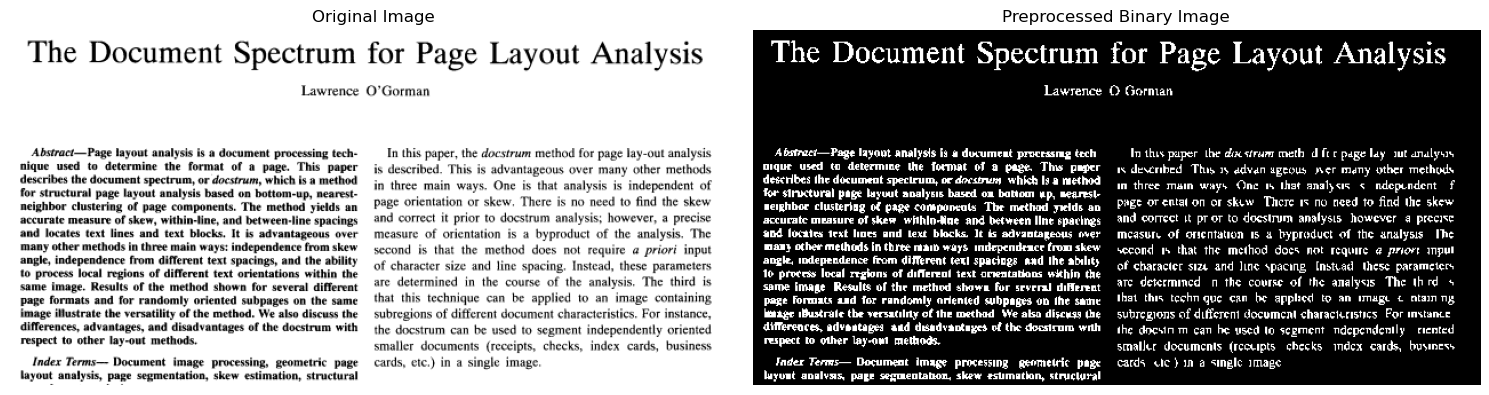

Found 1137 valid components


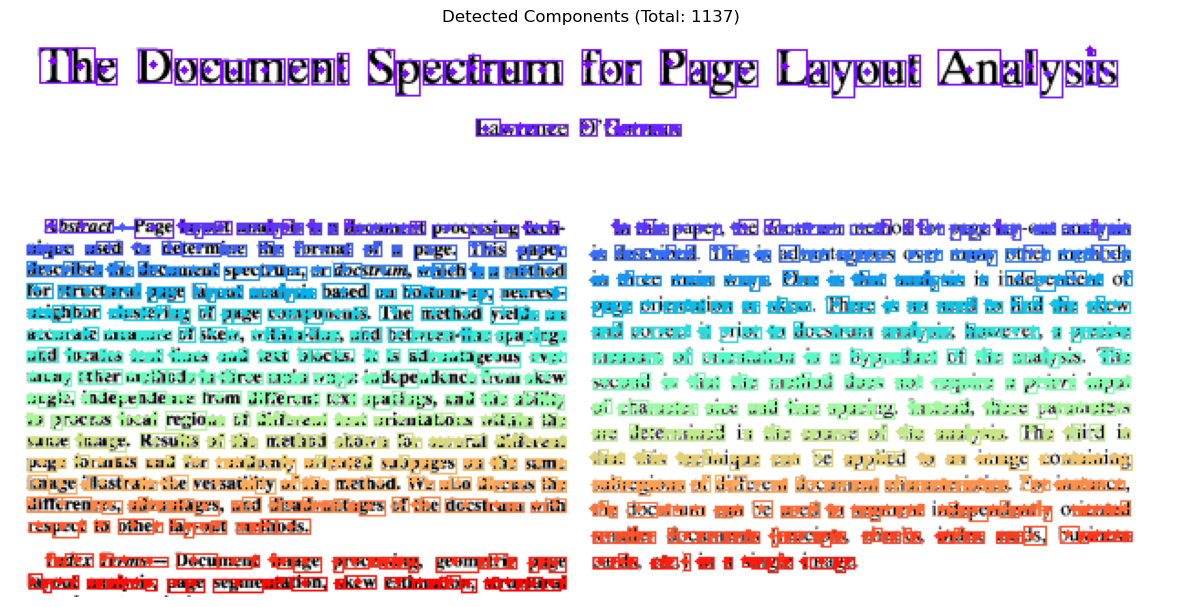

Finding 5 nearest neighbors for each component


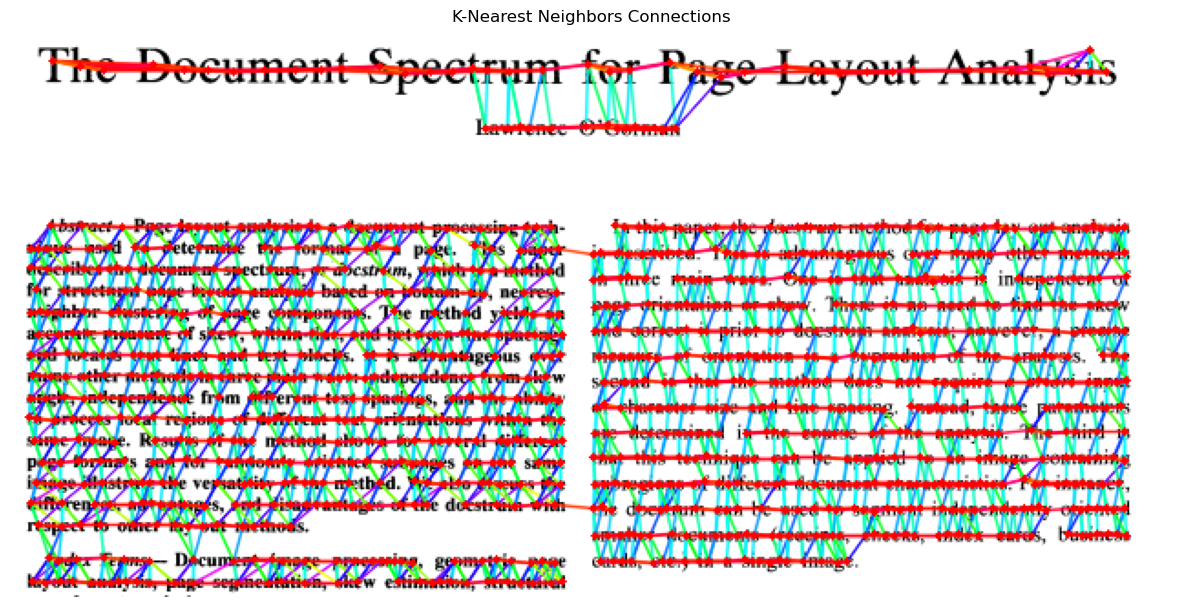

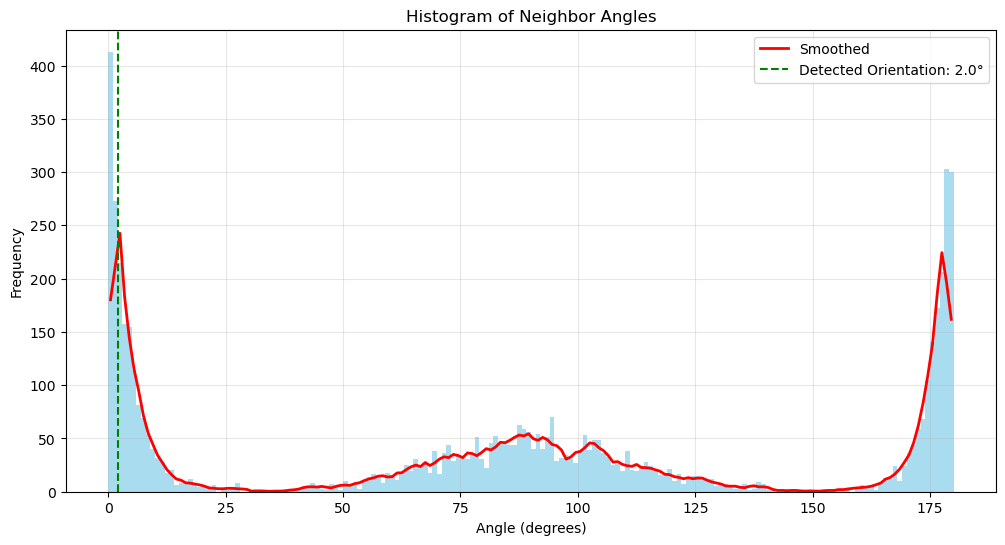

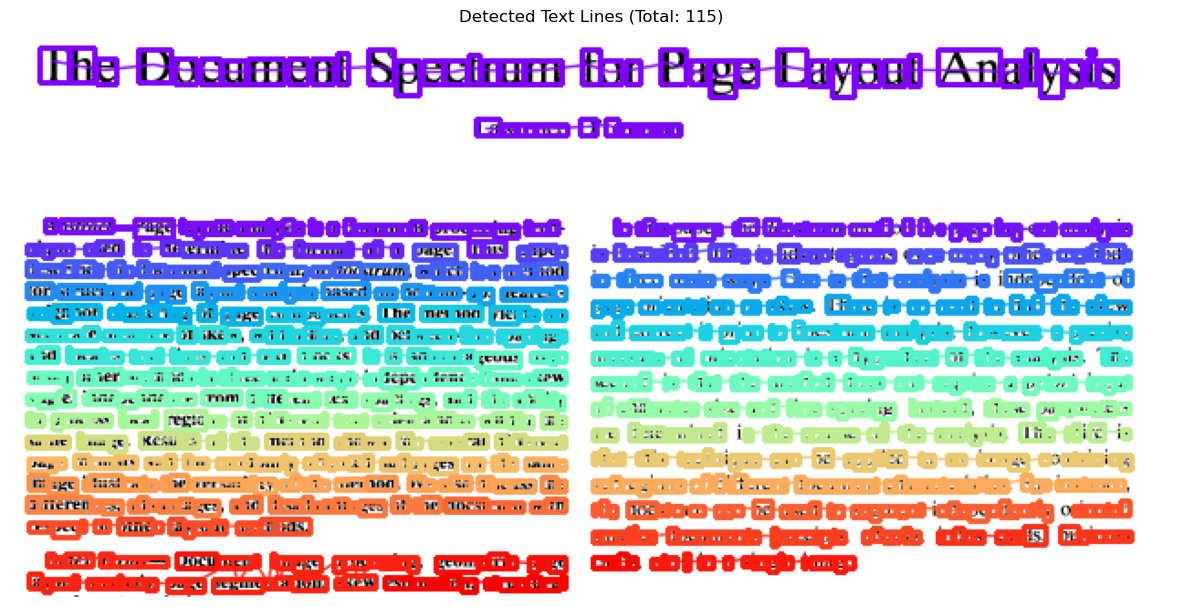

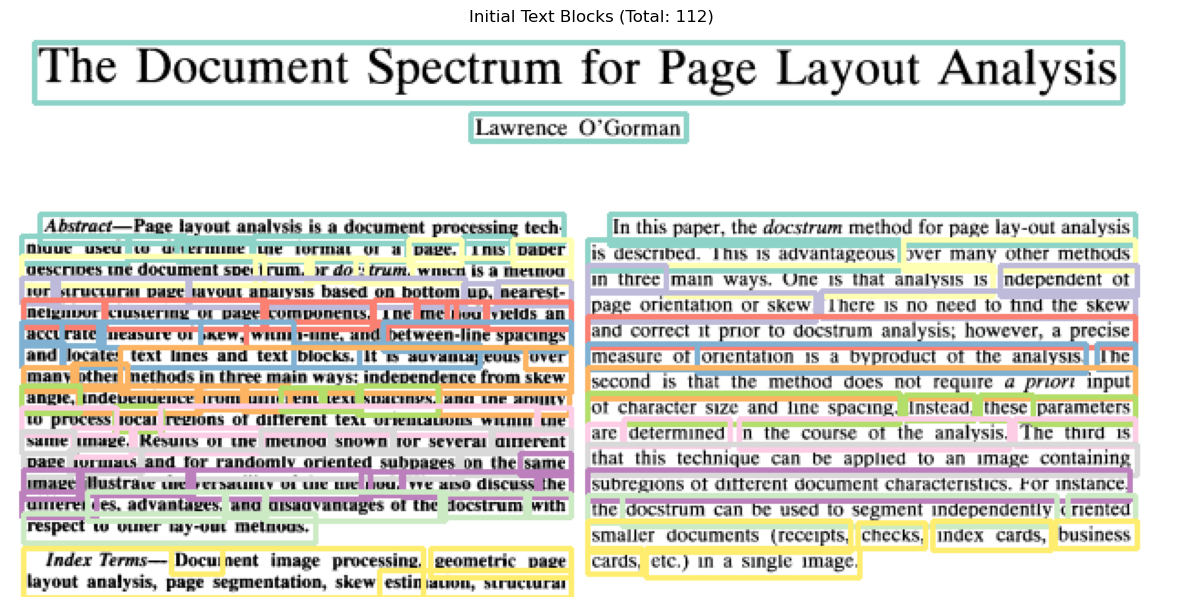

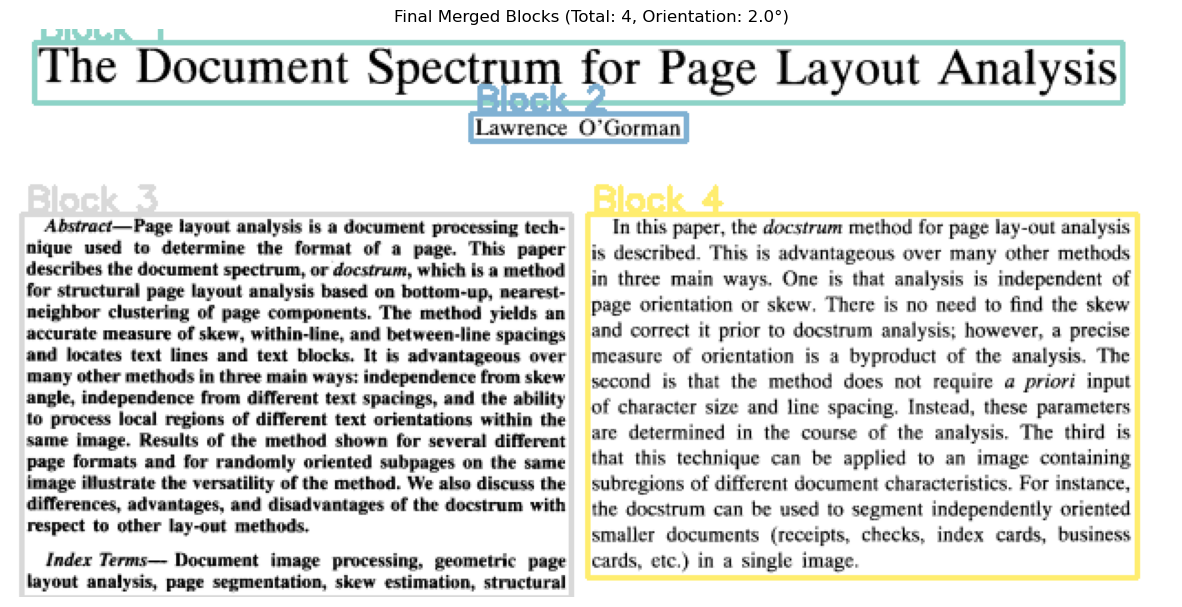

In [3]:
image_path = 'test1.png'

image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Create Docstrum processor
processor = Docstrum(k_nearest=5, angle_threshold=30)

# Process image with visualization
components, text_lines, orientation = processor.process(image, visualize=True)

Found 112 initial blocks
After merging: 4 blocks


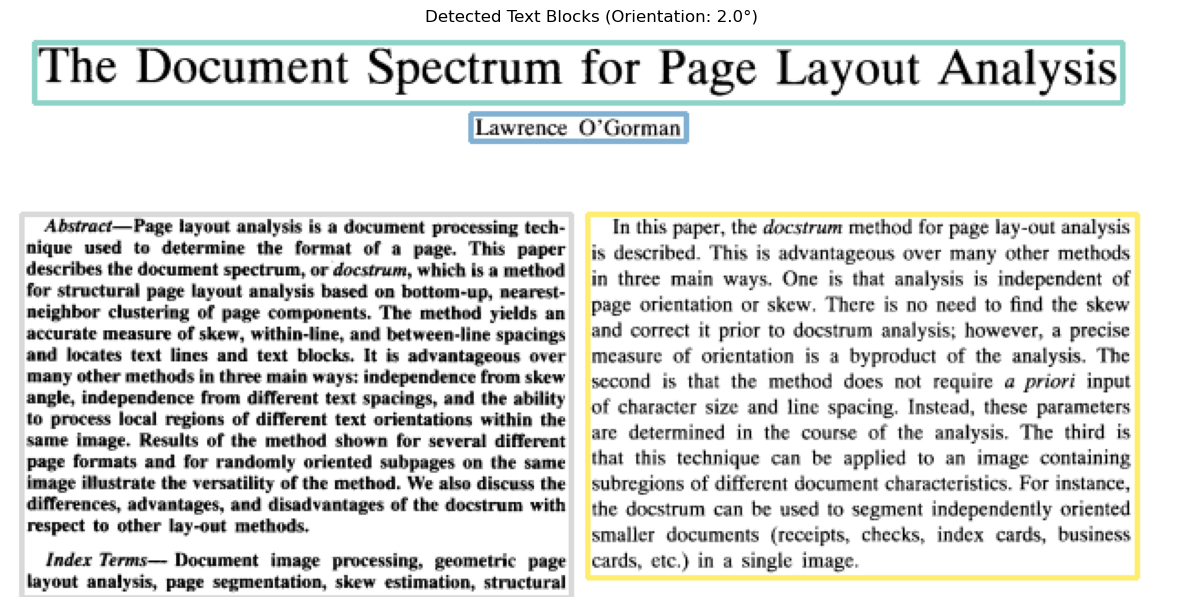

In [5]:
processor.visualize_results(image, components, text_lines, orientation)

Found 1137 valid components
Finding 5 nearest neighbors for each component
Processing complete:
- Found 1137 components
- Grouped into 115 text lines
- Estimated orientation: 2.0 degrees
Found 112 initial blocks
After merging: 4 blocks


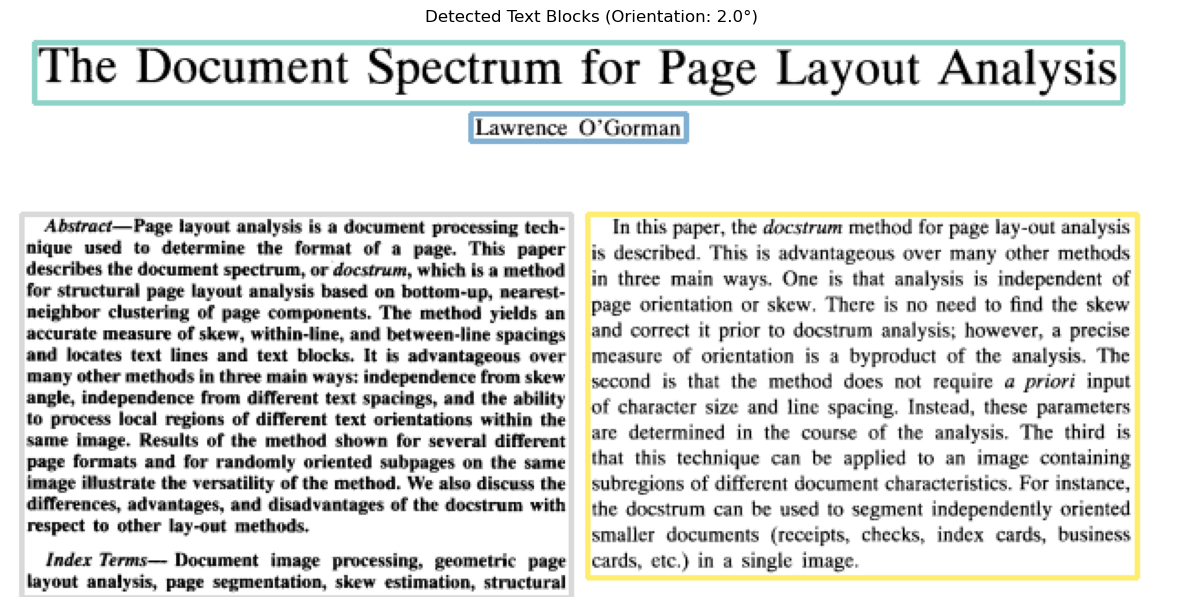

In [8]:
import argparse
import cv2
import sys
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
from dataclasses import dataclass


def remove_small_components(binary_image, k = 7):
    """
    Remove connected components smaller than a given size.

    Args:
        binary_image (numpy.ndarray): Binary image (1 for foreground, 0 for background).
        k (int): Minimum size of connected components to retain.

    Returns:
        numpy.ndarray: Binary image with small components removed.
    """
    # Label connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
    
    # Create an output image initialized to 0
    output_image = np.zeros_like(binary_image, dtype=np.uint8)
    
    # Iterate over each component
    for i in range(1, num_labels):  # Skip the background label (0)
        if stats[i, cv2.CC_STAT_AREA] >= k:
            # Retain components larger than or equal to k
            output_image[labels == i] = 1
    
    return output_image


@dataclass
class Component:
    """Class to store connected component information"""
    bbox: Tuple[int, int, int, int]  # x, y, w, h
    centroid: Tuple[float, float]
    area: int

class Docstrum:
    def __init__(self, k_nearest: int = 5, angle_threshold: float = 30):
        """
        Initialize docstrum processor
        
        Args:
            k_nearest: Number of nearest neighbors to find (default 5)
            angle_threshold: Angle threshold in degrees for within-line connections
        """
        self.k = k_nearest
        self.angle_threshold = angle_threshold

    def preprocess(self, image: np.ndarray) -> np.ndarray:
        """
        Preprocess the image - noise reduction and binarization
        
        Args:
            image: Input grayscale image
            
        Returns:
            Binary image
        """
        # Apply Otsu's thresholding
        _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Apply morphological operations to remove noise
        # kernel = np.ones((3,3), np.uint8)
        # binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        # binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        binary = (binary == 0).astype(np.uint8)

        binary = remove_small_components(binary, k=7)
        
        return binary

    def find_connected_components(self, binary: np.ndarray) -> List[Component]:
        """
        Find connected components in binary image and filter them based on size
        
        Args:
            binary: Binary image
            
        Returns:
            List of Component objects
        """
        # Invert binary image if needed (assuming text is black)
        if np.mean(binary) > 127:
            binary = cv2.bitwise_not(binary)
            
        # Find connected components
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)
        
        if num_labels < 2:  # 1 is background
            raise ValueError("No components found in the image")
        
        # Calculate median area to use for filtering
        areas = stats[1:, cv2.CC_STAT_AREA]  # Skip background
        median_area = np.median(areas)
        
        components = []
        # Skip background component (index 0)
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            
            # Filter out components that are too small or too large
            if area < median_area * 0.05 or area > median_area * 20:
                continue
                
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            
            components.append(Component(
                bbox=(x, y, w, h),
                centroid=(centroids[i][0], centroids[i][1]),
                area=area
            ))
        
        if not components:
            raise ValueError("No valid components found after filtering")
            
        print(f"Found {len(components)} valid components")
        return components

    def find_nearest_neighbors(self, components: List[Component]) -> List[List[Tuple[int, float, float]]]:
        """
        Find k nearest neighbors for each component
        
        Args:
            components: List of components
            
        Returns:
            List of lists containing (neighbor_idx, distance, angle) tuples for each component
        """
        if len(components) < self.k + 1:
            raise ValueError(f"Not enough components ({len(components)}) for k={self.k} nearest neighbors")
            
        # Extract centroids
        points = np.array([c.centroid for c in components])
        
        # Adjust k if necessary
        k = min(self.k + 1, len(components))
        print(f"Finding {k-1} nearest neighbors for each component")
        
        # Build KD-tree for efficient nearest neighbor search
        tree = KDTree(points)
        
        # Find k nearest neighbors (first one is the point itself)
        distances, indices = tree.query(points, k=k)
        
        neighbors_info = []
        for i, (component_neighbors, neighbor_distances) in enumerate(zip(indices, distances)):
            # Skip the first neighbor (point itself)
            neighbors = []
            for j, (neighbor_idx, dist) in enumerate(zip(component_neighbors[1:], neighbor_distances[1:]), 1):
                # Calculate angle between components
                dx = points[neighbor_idx][0] - points[i][0]
                dy = points[neighbor_idx][1] - points[i][1]
                angle = np.degrees(np.arctan2(dy, dx)) % 180
                
                neighbors.append((neighbor_idx, dist, angle))
            
            neighbors_info.append(neighbors)
            
        return neighbors_info

    # def find_nearest_neighbors(self, components: List[Component], spacing_factor: float = 2.) -> List[List[Tuple[int, float, float]]]:
    #     """
    #     Find k nearest neighbors for each component, filtering out those that are too far apart
    #     based on local inter-character spacing.
        
    #     Args:
    #         components: List of components
    #         spacing_factor: Factor to multiply with inter-character space for max distance threshold
            
    #     Returns:
    #         List of lists containing (neighbor_idx, distance, angle) tuples for each component
    #     """
    #     if len(components) < self.k + 1:
    #         raise ValueError(f"Not enough components ({len(components)}) for k={self.k} nearest neighbors")
            
    #     # Extract centroids and widths
    #     points = np.array([c.centroid for c in components])
    #     widths = np.array([c.bbox[2] for c in components])
        
    #     # Adjust k to get more candidates initially (we'll filter some out)
    #     initial_k = min(self.k * 2 + 1, len(components))
    #     print(f"Finding {initial_k-1} initial nearest neighbors for each component")
        
    #     # Build KD-tree for efficient nearest neighbor search
    #     tree = KDTree(points)
        
    #     # Find initial k nearest neighbors (first one is the point itself)
    #     distances, indices = tree.query(points, k=initial_k)
        
    #     neighbors_info = []
    #     for i, (component_neighbors, neighbor_distances) in enumerate(zip(indices, distances)):
    #         # Calculate local inter-character space based on nearest components
    #         # Use median width of current component and its closest neighbors
    #         local_widths = widths[component_neighbors[:min(5, len(component_neighbors))]]
    #         median_width = np.median(local_widths)
    #         max_distance = median_width * spacing_factor
            
    #         # Filter and process neighbors
    #         neighbors = []
    #         for j, (neighbor_idx, dist) in enumerate(zip(component_neighbors[1:], neighbor_distances[1:]), 1):
    #             # Skip if distance exceeds threshold
    #             if dist > max_distance:
    #                 continue
                    
    #             # Calculate angle between components
    #             dx = points[neighbor_idx][0] - points[i][0]
    #             dy = points[neighbor_idx][1] - points[i][1]
    #             angle = np.degrees(np.arctan2(dy, dx)) % 180
                
    #             neighbors.append((neighbor_idx, dist, angle))
                
    #             # Break if we have enough valid neighbors
    #             if len(neighbors) >= self.k:
    #                 break
            
    #         neighbors_info.append(neighbors)
            
    #     return neighbors_info


    def estimate_orientation(self, neighbors_info: List[List[Tuple[int, float, float]]]) -> float:
        """
        Estimate document orientation from neighbor angles
        
        Args:
            neighbors_info: List of neighbor information
            
        Returns:
            Estimated orientation angle in degrees
        """
        # Collect all angles
        angles = []
        for component_neighbors in neighbors_info:
            angles.extend([n[2] for n in component_neighbors])
            
        # Create histogram of angles
        hist, bins = np.histogram(angles, bins=180, range=(0, 180))
        
        # Apply smoothing to histogram
        hist = np.convolve(hist, np.ones(5)/5, mode='same')
        
        # Find peak
        orientation = bins[np.argmax(hist)]
        
        return orientation

    # def find_text_lines(self, components: List[Component], 
    #                    neighbors_info: List[List[Tuple[int, float, float]]], 
    #                    orientation: float) -> List[List[int]]:
    #     """
    #     Group components into text lines
        
    #     Args:
    #         components: List of components
    #         neighbors_info: List of neighbor information
    #         orientation: Estimated text orientation
            
    #     Returns:
    #         List of text lines, where each line is a list of component indices
    #     """
    #     # Create graph of connected components
    #     graph = {i: [] for i in range(len(components))}
        
    #     for i, component_neighbors in enumerate(neighbors_info):
    #         for neighbor_idx, dist, angle in component_neighbors:
    #             # Check if angle is within threshold of orientation
    #             angle_diff = min((angle - orientation) % 180, (orientation - angle) % 180)
    #             if angle_diff < self.angle_threshold:
    #                 graph[i].append(neighbor_idx)
    #                 graph[neighbor_idx].append(i)
        
    #     # Find connected components in graph (text lines)
    #     text_lines = []
    #     visited = set()
        
    #     def dfs(node: int, current_line: List[int]):
    #         visited.add(node)
    #         current_line.append(node)
    #         for neighbor in graph[node]:
    #             if neighbor not in visited:
    #                 dfs(neighbor, current_line)
        
    #     for i in range(len(components)):
    #         if i not in visited:
    #             current_line = []
    #             dfs(i, current_line)
    #             # Sort components in line by x-coordinate for left-to-right reading
    #             current_line.sort(key=lambda idx: components[idx].centroid[0])
    #             text_lines.append(current_line)
        
    #     # Sort text lines by y-coordinate (top to bottom)
    #     text_lines.sort(key=lambda line: min(components[idx].centroid[1] for idx in line))
        
    #     return text_lines

    def find_text_lines(self, components: List[Component], 
                    neighbors_info: List[List[Tuple[int, float, float]]], 
                    orientation: float,
                    spacing_factor: float = 1.2) -> List[List[int]]:
        """
        Group components into text lines, considering local intercharacter spacing
        
        Args:
            components: List of components
            neighbors_info: List of neighbor information
            orientation: Estimated text orientation
            spacing_factor: Factor to multiply local intercharacter space for max allowed gap
                
        Returns:
            List of text lines, where each line is a list of component indices
        """
        def calculate_local_spacing(component_idx: int, potential_neighbors: List[int]) -> float:
            """Calculate median intercharacter spacing for a component and its aligned neighbors"""
            if not potential_neighbors:
                return float('inf')
                
            # Get horizontal gaps between component and its aligned neighbors
            gaps = []
            comp = components[component_idx]
            
            for n_idx in potential_neighbors:
                neighbor = components[n_idx]
                
                # Determine which component is leftmost
                if comp.centroid[0] < neighbor.centroid[0]:
                    left, right = comp, neighbor
                    left_idx, right_idx = component_idx, n_idx
                else:
                    left, right = neighbor, comp
                    left_idx, right_idx = n_idx, component_idx
                    
                # Calculate gap between components
                gap = (right.bbox[0] - (left.bbox[0] + left.bbox[2]))
                if gap > 0:  # Only consider positive gaps
                    gaps.append(gap)
                    
            return np.median(gaps) if gaps else float('inf')
        
        # Create graph of connected components
        graph = {i: [] for i in range(len(components))}
        
        # First pass: Find potentially aligned components
        aligned_components = {i: [] for i in range(len(components))}
        for i, component_neighbors in enumerate(neighbors_info):
            for neighbor_idx, dist, angle in component_neighbors:
                # Check if angle is within threshold of orientation
                angle_diff = min((angle - orientation) % 180, (orientation - angle) % 180)
                if angle_diff < self.angle_threshold:
                    aligned_components[i].append(neighbor_idx)
                    aligned_components[neighbor_idx].append(i)
        
        # Second pass: Apply local spacing constraints
        for i in range(len(components)):
            # Calculate local spacing for current component
            local_spacing = calculate_local_spacing(i, aligned_components[i])
            
            # Add edges only if components are within local spacing constraint
            for neighbor_idx in aligned_components[i]:
                comp = components[i]
                neighbor = components[neighbor_idx]
                
                # Calculate horizontal distance between components
                if comp.centroid[0] < neighbor.centroid[0]:
                    left, right = comp, neighbor
                else:
                    left, right = neighbor, comp
                    
                distance = right.bbox[0] - (left.bbox[0] + left.bbox[2])
                
                # Only add edge if distance is within local spacing constraint
                if distance <= local_spacing * spacing_factor:
                    graph[i].append(neighbor_idx)
                    graph[neighbor_idx].append(i)
        
        # Find connected components in graph (text lines)
        text_lines = []
        visited = set()
        
        def dfs(node: int, current_line: List[int]):
            visited.add(node)
            current_line.append(node)
            for neighbor in graph[node]:
                if neighbor not in visited:
                    dfs(neighbor, current_line)
        
        for i in range(len(components)):
            if i not in visited:
                current_line = []
                dfs(i, current_line)
                # Sort components in line by x-coordinate for left-to-right reading
                current_line.sort(key=lambda idx: components[idx].centroid[0])
                text_lines.append(current_line)
        
        # Sort text lines by y-coordinate (top to bottom)
        text_lines.sort(key=lambda line: min(components[idx].centroid[1] for idx in line))
        
        return text_lines
        
    def find_blocks(self, components: List[Component], text_lines: List[List[int]], 
                   max_vertical_gap: float = 2.5) -> List[List[List[int]]]:
        """
        Group text lines into blocks based on vertical spacing
        
        Args:
            components: List of components
            text_lines: List of text lines
            max_vertical_gap: Maximum allowed vertical gap between lines in a block,
                            as a factor of median line spacing
            
        Returns:
            List of blocks, where each block is a list of text lines
        """
        if not text_lines:
            return []
            
        # Calculate median line spacing
        line_spacings = []
        for i in range(len(text_lines) - 1):
            current_line_bottom = max(components[idx].bbox[1] + components[idx].bbox[3] 
                                    for idx in text_lines[i])
            next_line_top = min(components[idx].bbox[1] 
                              for idx in text_lines[i + 1])
            line_spacings.append(next_line_top - current_line_bottom)
            
        if not line_spacings:
            return [text_lines]  # Single block with all lines
            
        median_spacing = np.median(line_spacings) *1.2
        
        # Group lines into blocks
        blocks = []
        current_block = [text_lines[0]]
        
        for i in range(1, len(text_lines)):
            current_line = text_lines[i]
            prev_line = text_lines[i - 1]
            
            # Calculate vertical gap between lines
            prev_line_bottom = max(components[idx].bbox[1] + components[idx].bbox[3] 
                                 for idx in prev_line)
            current_line_top = min(components[idx].bbox[1] 
                                 for idx in current_line)
            gap = current_line_top - prev_line_bottom
            
            if gap > median_spacing * max_vertical_gap:
                # Start new block
                blocks.append(current_block)
                current_block = [current_line]
            else:
                # Add to current block
                current_block.append(current_line)
        
        # Add last block
        blocks.append(current_block)
        
        return blocks

    def process(self, image: np.ndarray, visualize: bool = True) -> Tuple[List[Component], List[List[int]], float]:
        """
        Main processing function with visualization
        
        Args:
            image: Input grayscale image
            visualize: Whether to show visualization plots
            
        Returns:
            Tuple containing:
            - List of components
            - List of text lines
            - Estimated orientation
        """
        # Preprocess image
        binary = self.preprocess(image)
        if visualize:
            visualize_preprocessing(image, binary)
        
        # Find connected components
        components = self.find_connected_components(binary)
        if visualize:
            visualize_components(image, components)
        
        # Find nearest neighbors
        neighbors_info = self.find_nearest_neighbors(components)
        if visualize:
            visualize_neighbors(image, components, neighbors_info)
        
        # Estimate orientation
        orientation = self.estimate_orientation(neighbors_info)
        if visualize:
            visualize_orientation_histogram(neighbors_info, orientation)
        
        # Find text lines
        text_lines = self.find_text_lines(components, neighbors_info, orientation)
        if visualize:
            visualize_text_lines(image, components, text_lines)
        
        # Find initial blocks
        initial_blocks = self.find_blocks(components, text_lines)
        if visualize:
            visualize_initial_blocks(image, components, initial_blocks)
        
        # Merge blocks
        merged_blocks = self.merge_overlapping_blocks(components, initial_blocks)
        if visualize:
            visualize_merged_blocks(image, components, merged_blocks, orientation)
        
        return components, text_lines, orientation
    # def merge_overlapping_blocks(self, components: List[Component], blocks: List[List[List[int]]], 
    #                         overlap_threshold: float = 0.3) -> List[List[List[int]]]:
    #     """
    #     Merge blocks that overlap significantly
        
    #     Args:
    #         components: List of components
    #         blocks: List of blocks (each block is a list of text lines)
    #         overlap_threshold: Minimum overlap ratio to merge blocks (0 to 1)
            
    #     Returns:
    #         List of merged blocks
    #     """
    #     def get_block_bounds(block):
    #         # Get all component indices in the block
    #         block_components = [comp_idx for line in block for comp_idx in line]
    #         if not block_components:
    #             return None
                
    #         # Find block boundaries
    #         min_x = min(components[idx].bbox[0] for idx in block_components)
    #         min_y = min(components[idx].bbox[1] for idx in block_components)
    #         max_x = max(components[idx].bbox[0] + components[idx].bbox[2] 
    #                 for idx in block_components)
    #         max_y = max(components[idx].bbox[1] + components[idx].bbox[3] 
    #                 for idx in block_components)
            
    #         return (min_x, min_y, max_x, max_y)
        
    #     def compute_overlap(bounds1, bounds2):
    #         if not bounds1 or not bounds2:
    #             return 0
                
    #         x1, y1, x2, y2 = bounds1
    #         x3, y3, x4, y4 = bounds2
            
    #         # Calculate intersection
    #         x_left = max(x1, x3)
    #         y_top = max(y1, y3)
    #         x_right = min(x2, x4)
    #         y_bottom = min(y2, y4)
            
    #         if x_right < x_left or y_bottom < y_top:
    #             return 0
                
    #         intersection = (x_right - x_left) * (y_bottom - y_top)
            
    #         # Calculate areas
    #         area1 = (x2 - x1) * (y2 - y1)
    #         area2 = (x4 - x3) * (y4 - y3)
            
    #         # Return overlap ratio (intersection over minimum area)
    #         return intersection / min(area1, area2)
        
    #     # Continue merging until no more merges are possible
    #     while True:
    #         merged = False
            
    #         # Get bounds for all blocks
    #         block_bounds = [get_block_bounds(block) for block in blocks]
            
    #         # Check each pair of blocks
    #         for i in range(len(blocks)):
    #             if i >= len(blocks):  # Check if block was removed
    #                 continue
                    
    #             for j in range(i + 1, len(blocks)):
    #                 if j >= len(blocks):  # Check if block was removed
    #                     continue
                        
    #                 # Compute overlap between blocks
    #                 overlap = compute_overlap(block_bounds[i], block_bounds[j])
                    
    #                 if overlap > overlap_threshold:
    #                     # Merge blocks
    #                     blocks[i].extend(blocks[j])
    #                     # Sort lines in merged block by y-coordinate
    #                     blocks[i].sort(key=lambda line: min(components[idx].centroid[1] 
    #                                                     for idx in line))
    #                     # Remove merged block
    #                     blocks.pop(j)
    #                     block_bounds.pop(j)
    #                     merged = True
    #                     break
                
    #             if merged:
    #                 break
                    
    #         if not merged:
    #             break
        
    #     return blocks


    def merge_overlapping_blocks(self, components: List[Component], blocks: List[List[List[int]]], 
                                overlap_threshold: float = 0.3,
                                alignment_threshold: float = 0.25,
                                corner_threshold: float = 15) -> List[List[List[int]]]:
        """
        Merge blocks that:
        1. Overlap horizontally or vertically with similar alignments
        2. One block is contained within another
        3. Share approximately similar borders (via corner proximity)
        
        Args:
            components: List of components
            blocks: List of blocks (each block is a list of text lines)
            overlap_threshold: Minimum overlap ratio to merge blocks (0 to 1)
            alignment_threshold: Maximum allowed difference in alignment relative to block size
            corner_threshold: Maximum distance between corners to consider them as sharing a border
            
        Returns:
            List of merged blocks
        """
        def get_block_bounds(block):
            # Get all component indices in the block
            block_components = [comp_idx for line in block for comp_idx in line]
            if not block_components:
                return None
                
            # Find block boundaries
            min_x = min(components[idx].bbox[0] for idx in block_components)
            min_y = min(components[idx].bbox[1] for idx in block_components)
            max_x = max(components[idx].bbox[0] + components[idx].bbox[2] 
                    for idx in block_components)
            max_y = max(components[idx].bbox[1] + components[idx].bbox[3] 
                    for idx in block_components)
            
            return (min_x, min_y, max_x, max_y)
        
        def compute_horizontal_overlap(bounds1, bounds2):
            if not bounds1 or not bounds2:
                return 0
                
            x1, _, x2, _ = bounds1
            x3, _, x4, _ = bounds2
            
            # Calculate horizontal intersection
            overlap = max(0, min(x2, x4) - max(x1, x3))
            
            # Calculate widths
            width1 = x2 - x1
            width2 = x4 - x3
            
            # Return overlap ratio
            return overlap / min(width1, width2)
        
        def compute_vertical_overlap(bounds1, bounds2):
            if not bounds1 or not bounds2:
                return 0
                
            _, y1, _, y2 = bounds1
            _, y3, _, y4 = bounds2
            
            # Calculate vertical intersection
            overlap = max(0, min(y2, y4) - max(y1, y3))
            
            # Calculate heights
            height1 = y2 - y1
            height2 = y4 - y3
            
            # Return overlap ratio
            return overlap / min(height1, height2)
        
        def check_horizontal_alignment(bounds1, bounds2):
            _, y1, _, y2 = bounds1
            _, y3, _, y4 = bounds2
            
            height1 = y2 - y1
            height2 = y4 - y3
            
            # Check if vertical positions are similar relative to block heights
            y_diff = abs((y1 + y2)/2 - (y3 + y4)/2)
            return y_diff <= alignment_threshold * max(height1, height2)
        
        def check_vertical_alignment(bounds1, bounds2):
            x1, _, x2, _ = bounds1
            x3, _, x4, _ = bounds2
            
            width1 = x2 - x1
            width2 = x4 - x3
            
            # Check if horizontal positions are similar relative to block widths
            x_diff = abs((x1 + x2)/2 - (x3 + x4)/2)
            return x_diff <= alignment_threshold * max(width1, width2)

        def check_containment(bounds1, bounds2):
            """Check if either block is contained within the other"""
            if not bounds1 or not bounds2:
                return False
                
            x1, y1, x2, y2 = bounds1
            x3, y3, x4, y4 = bounds2
            
            # Check if bounds1 is contained in bounds2
            contained_in_2 = (x3 <= x1 and x2 <= x4 and 
                            y3 <= y1 and y2 <= y4)
            
            # Check if bounds2 is contained in bounds1
            contained_in_1 = (x1 <= x3 and x4 <= x2 and 
                            y1 <= y3 and y4 <= y2)
            
            return contained_in_1 or contained_in_2

        def check_shared_border(bounds1, bounds2):
            """Check if blocks share approximately similar borders (via corner proximity)"""
            if not bounds1 or not bounds2:
                return False
                
            x1, y1, x2, y2 = bounds1
            x3, y3, x4, y4 = bounds2
            
            # Get corners for both blocks
            corners1 = [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]
            corners2 = [(x3, y3), (x3, y4), (x4, y3), (x4, y4)]
            
            # Count how many corners are close to each other
            close_corners = 0
            for c1 in corners1:
                for c2 in corners2:
                    distance = np.sqrt((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2)
                    if distance <= corner_threshold:
                        close_corners += 1
                        
            # Return True if at least 2 corners are close (indicating shared border)
            return close_corners >= 2
        
        # Continue merging until no more merges are possible
        while True:
            merged = False
            
            # Get bounds for all blocks
            block_bounds = [get_block_bounds(block) for block in blocks]
            
            # Check each pair of blocks
            for i in range(len(blocks)):
                if i >= len(blocks):  # Check if block was removed
                    continue
                    
                for j in range(i + 1, len(blocks)):
                    if j >= len(blocks):  # Check if block was removed
                        continue
                        
                    bounds1 = block_bounds[i]
                    bounds2 = block_bounds[j]
                    
                    # Check all merge conditions
                    h_overlap = compute_horizontal_overlap(bounds1, bounds2)
                    h_aligned = check_horizontal_alignment(bounds1, bounds2)
                    v_overlap = compute_vertical_overlap(bounds1, bounds2)
                    v_aligned = check_vertical_alignment(bounds1, bounds2)
                    is_contained = check_containment(bounds1, bounds2)
                    shares_border = check_shared_border(bounds1, bounds2)
                    
                    # Merge if any of the conditions are met
                    if ((h_overlap > overlap_threshold and h_aligned) or 
                        (v_overlap > overlap_threshold and v_aligned) or
                        is_contained or shares_border):
                        # Merge blocks
                        blocks[i].extend(blocks[j])
                        # Sort lines in merged block by y-coordinate
                        blocks[i].sort(key=lambda line: min(components[idx].centroid[1] 
                                                        for idx in line))
                        # Remove merged block
                        blocks.pop(j)
                        block_bounds.pop(j)
                        merged = True
                        break
                
                if merged:
                    break
                    
            if not merged:
                break
        
        return blocks

    def find_blocks(self, components: List[Component], text_lines: List[List[int]], 
                max_vertical_gap: float = 1.5, horizontal_overlap_threshold: float = 0.5) -> List[List[List[int]]]:
        """
        Improved block detection with stricter merging criteria
        
        Args:
            components: List of components
            text_lines: List of text lines
            max_vertical_gap: Maximum vertical gap multiplier (smaller = stricter)
            horizontal_overlap_threshold: Required horizontal overlap ratio (larger = stricter)
        """
        if not text_lines:
            return []
            
        def get_line_bounds(line):
            x1 = min(components[idx].bbox[0] for idx in line)
            y1 = min(components[idx].bbox[1] for idx in line)
            x2 = max(components[idx].bbox[0] + components[idx].bbox[2] for idx in line)
            y2 = max(components[idx].bbox[1] + components[idx].bbox[3] for idx in line)
            return (x1, y1, x2, y2)

        def get_line_height(line):
            heights = [components[idx].bbox[3] for idx in line]
            return np.median(heights)
        
        def horizontal_overlap_ratio(bounds1, bounds2):
            x1, _, x2, _ = bounds1
            x3, _, x4, _ = bounds2
            overlap = min(x2, x4) - max(x1, x3)
            if overlap <= 0:
                return 0
            width1 = x2 - x1
            width2 = x4 - x3
            return overlap / min(width1, width2)
        
        # Calculate typical line spacing
        line_spacings = []
        line_bounds = [get_line_bounds(line) for line in text_lines]
        line_heights = [get_line_height(line) for line in text_lines]
        
        for i in range(len(text_lines) - 1):
            _, _, _, y2 = line_bounds[i]
            _, y3, _, _ = line_bounds[i + 1]
            line_spacings.append(y3 - y2)
        
        if not line_spacings:
            return [text_lines]
            
        median_spacing = np.median(line_spacings)
        median_height = np.median(line_heights)
        
        # Group lines into initial blocks
        blocks = []
        current_block = [text_lines[0]]
        current_bounds = line_bounds[0]
        
        for i in range(1, len(text_lines)):
            current_line = text_lines[i]
            current_line_bounds = line_bounds[i]
            
            # Check vertical gap
            _, _, _, prev_bottom = current_bounds
            _, curr_top, _, _ = current_line_bounds
            vertical_gap = curr_top - prev_bottom
            
            # Check horizontal overlap with previous line
            overlap = horizontal_overlap_ratio(current_bounds, current_line_bounds)
            
            # Stricter merging conditions:
            # 1. Must have significant horizontal overlap
            # 2. Vertical gap must be reasonable
            # 3. Consider line height in spacing calculation
            if (overlap > horizontal_overlap_threshold and 
                vertical_gap <= max(median_spacing * max_vertical_gap, median_height * 1.5)):
                current_block.append(current_line)
                # Update bounds
                x1 = min(current_bounds[0], current_line_bounds[0])
                y1 = min(current_bounds[1], current_line_bounds[1])
                x2 = max(current_bounds[2], current_line_bounds[2])
                y2 = max(current_bounds[3], current_line_bounds[3])
                current_bounds = (x1, y1, x2, y2)
            else:
                blocks.append(current_block)
                current_block = [current_line]
                current_bounds = current_line_bounds
        
        blocks.append(current_block)
        return blocks

    def visualize_results(self, image: np.ndarray, components: List[Component], 
                        text_lines: List[List[int]], orientation: float):
        """
        Visualize results with both initial and merged blocks
        """
        # Create RGB visualization image
        vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
        
        # Find initial blocks
        initial_blocks = self.find_blocks(components, text_lines)
        print(f"Found {len(initial_blocks)} initial blocks")
        
        # Merge blocks based on corner proximity
        merged_blocks = self.merge_overlapping_blocks(components, initial_blocks)
        print(f"After merging: {len(merged_blocks)} blocks")
        
        # Generate distinct colors for blocks (avoiding similar colors)
        colors = plt.cm.Set3(np.linspace(0, 1, len(merged_blocks)))
        colors = (colors[:, :3] * 255).astype(int)
        
        # Draw merged blocks
        for block_idx, block in enumerate(merged_blocks):
            # Get all components in block
            block_components = [comp_idx for line in block for comp_idx in line]
            
            if not block_components:
                continue
                
            # Find block boundaries
            min_x = min(components[idx].bbox[0] for idx in block_components)
            min_y = min(components[idx].bbox[1] for idx in block_components)
            max_x = max(components[idx].bbox[0] + components[idx].bbox[2] 
                    for idx in block_components)
            max_y = max(components[idx].bbox[1] + components[idx].bbox[3] 
                    for idx in block_components)
            
            # Draw block rectangle with padding
            color = colors[block_idx % len(colors)].tolist()
            padding = 3
            cv2.rectangle(vis_image, 
                        (min_x - padding, min_y - padding), 
                        (max_x + padding, max_y + padding), 
                        color, 2)
        
        plt.figure(figsize=(15, 10))
        plt.imshow(vis_image)
        plt.title(f'Detected Text Blocks (Orientation: {orientation:.1f}°)')
        plt.axis('off')
        plt.show()

        




def visualize_preprocessing(image: np.ndarray, binary: np.ndarray):
    """
    Visualize the preprocessing step showing original and binary images side by side
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Show original image
    ax1.imshow(image, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Show binary image
    ax2.imshow(binary, cmap='gray')
    ax2.set_title('Preprocessed Binary Image')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_components(image: np.ndarray, components: List[Component]):
    """
    Visualize detected connected components with bounding boxes and centroids
    """
    # Create RGB visualization image
    vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    # Generate distinct colors
    colors = plt.cm.rainbow(np.linspace(0, 1, len(components)))
    colors = (colors[:, :3] * 255).astype(int)
    
    # Draw components
    for idx, comp in enumerate(components):
        color = colors[idx % len(colors)].tolist()
        x, y, w, h = comp.bbox
        
        # Draw bounding box
        cv2.rectangle(vis_image, (x, y), (x + w, y + h), color, 1)
        
        # Draw centroid
        cx, cy = map(int, comp.centroid)
        cv2.circle(vis_image, (cx, cy), 2, color, -1)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(vis_image)
    plt.title(f'Detected Components (Total: {len(components)})')
    plt.axis('off')
    plt.show()

def visualize_neighbors(image: np.ndarray, components: List[Component], 
                    neighbors_info: List[List[Tuple[int, float, float]]]):
    """
    Visualize k-nearest neighbors connections between components
    """
    # Create RGB visualization image
    vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    # Draw connections between components
    for i, component_neighbors in enumerate(neighbors_info):
        x1, y1 = map(int, components[i].centroid)
        
        for neighbor_idx, dist, angle in component_neighbors:
            x2, y2 = map(int, components[neighbor_idx].centroid)
            
            # Color based on angle (cyclic color map)
            color = plt.cm.hsv(angle / 180)[:3]
            color = tuple(int(c * 255) for c in color)
            
            # Draw line connecting components
            cv2.line(vis_image, (x1, y1), (x2, y2), color, 1, cv2.LINE_AA)
    
    # Draw component centroids on top
    for comp in components:
        cx, cy = map(int, comp.centroid)
        cv2.circle(vis_image, (cx, cy), 2, (255, 0, 0), -1)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(vis_image)
    plt.title('K-Nearest Neighbors Connections')
    plt.axis('off')
    plt.show()

def visualize_orientation_histogram(neighbors_info: List[List[Tuple[int, float, float]]], 
                                orientation: float):
    """
    Visualize histogram of angles and detected orientation
    """
    # Collect all angles
    angles = []
    for component_neighbors in neighbors_info:
        angles.extend([n[2] for n in component_neighbors])
        
    # Create histogram
    plt.figure(figsize=(12, 6))
    hist, bins, _ = plt.hist(angles, bins=180, range=(0, 180), 
                            color='skyblue', alpha=0.7)
    
    # Apply smoothing for visualization
    smoothed = np.convolve(hist, np.ones(5)/5, mode='same')
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, smoothed, 'r-', linewidth=2, label='Smoothed')
    
    # Mark detected orientation
    plt.axvline(x=orientation, color='green', linestyle='--', 
                label=f'Detected Orientation: {orientation:.1f}°')
    
    plt.title('Histogram of Neighbor Angles')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def visualize_text_lines(image: np.ndarray, components: List[Component], 
                        text_lines: List[List[int]]):
    """
    Visualize detected text lines with different colors
    """
    # Create RGB visualization image
    vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    # Generate distinct colors for lines
    colors = plt.cm.rainbow(np.linspace(0, 1, len(text_lines)))
    colors = (colors[:, :3] * 255).astype(int)
    
    # Draw text lines
    for line_idx, line in enumerate(text_lines):
        color = colors[line_idx % len(colors)].tolist()
        
        # Draw bounding boxes for components in line
        for comp_idx in line:
            x, y, w, h = components[comp_idx].bbox
            cv2.rectangle(vis_image, (x, y), (x + w, y + h), color, 2)
        
        # Connect components in line
        if len(line) > 1:
            for i in range(len(line) - 1):
                x1, y1 = components[line[i]].centroid
                x2, y2 = components[line[i + 1]].centroid
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                cv2.line(vis_image, (x1, y1), (x2, y2), color, 1, cv2.LINE_AA)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(vis_image)
    plt.title(f'Detected Text Lines (Total: {len(text_lines)})')
    plt.axis('off')
    plt.show()

def visualize_initial_blocks(image: np.ndarray, components: List[Component], 
                        blocks: List[List[List[int]]]):
    """
    Visualize initial text blocks before merging
    """
    # Create RGB visualization image
    vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    # Generate distinct colors for blocks
    colors = plt.cm.Set3(np.linspace(0, 1, len(blocks)))
    colors = (colors[:, :3] * 255).astype(int)
    
    # Draw blocks
    for block_idx, block in enumerate(blocks):
        color = colors[block_idx % len(colors)].tolist()
        
        # Get all components in block
        block_components = [comp_idx for line in block for comp_idx in line]
        
        if not block_components:
            continue
            
        # Find block boundaries
        min_x = min(components[idx].bbox[0] for idx in block_components)
        min_y = min(components[idx].bbox[1] for idx in block_components)
        max_x = max(components[idx].bbox[0] + components[idx].bbox[2] 
                for idx in block_components)
        max_y = max(components[idx].bbox[1] + components[idx].bbox[3] 
                for idx in block_components)
        
        # Draw block rectangle
        padding = 3
        cv2.rectangle(vis_image, 
                    (min_x - padding, min_y - padding), 
                    (max_x + padding, max_y + padding), 
                    color, 2)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(vis_image)
    plt.title(f'Initial Text Blocks (Total: {len(blocks)})')
    plt.axis('off')
    plt.show()

def visualize_merged_blocks(image: np.ndarray, components: List[Component], 
                        blocks: List[List[List[int]]], orientation: float):
    """
    Visualize final merged blocks
    """
    # Create RGB visualization image
    vis_image = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)
    
    # Generate distinct colors for blocks
    colors = plt.cm.Set3(np.linspace(0, 1, len(blocks)))
    colors = (colors[:, :3] * 255).astype(int)
    
    # Draw blocks
    for block_idx, block in enumerate(blocks):
        color = colors[block_idx % len(colors)].tolist()
        
        # Get all components in block
        block_components = [comp_idx for line in block for comp_idx in line]
        
        if not block_components:
            continue
            
        # Find block boundaries
        min_x = min(components[idx].bbox[0] for idx in block_components)
        min_y = min(components[idx].bbox[1] for idx in block_components)
        max_x = max(components[idx].bbox[0] + components[idx].bbox[2] 
                for idx in block_components)
        max_y = max(components[idx].bbox[1] + components[idx].bbox[3] 
                for idx in block_components)
        
        # Draw block rectangle with label
        padding = 3
        cv2.rectangle(vis_image, 
                    (min_x - padding, min_y - padding), 
                    (max_x + padding, max_y + padding), 
                    color, 2)
        
        # Add block number label
        cv2.putText(vis_image, f'Block {block_idx + 1}', 
                (min_x, min_y - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    plt.figure(figsize=(15, 10))
    plt.imshow(vis_image)
    plt.title(f'Final Merged Blocks (Total: {len(blocks)}, Orientation: {orientation:.1f}°)')
    plt.axis('off')
    plt.show()




# def main():
#     # Create argument parser
#     parser = argparse.ArgumentParser(description='Run Docstrum page layout analysis on an image.')
#     parser.add_argument('image_path', type=str, default = 'test1.png', help='Path to the input image')
#     parser.add_argument('--k_nearest', type=int, default=5, 
#                        help='Number of nearest neighbors (default: 5)')
#     parser.add_argument('--angle_threshold', type=float, default=30, 
#                        help='Angle threshold in degrees (default: 30)')
    
#     # Parse arguments
#     args = parser.parse_args()
    
#     # Load and process image
#     image = cv2.imread(args.image_path, cv2.IMREAD_GRAYSCALE)
#     if image is None:
#         print(f"Error: Could not load image {args.image_path}")
#         sys.exit(1)
        
#     print(f"Loaded image with shape: {image.shape}")
    
#     try:
#         # Initialize and run docstrum
#         docstrum = Docstrum(k_nearest=args.k_nearest, angle_threshold=args.angle_threshold)
#         components, text_lines, orientation = docstrum.process(image, visualize= False)
        
#         print(f"Processing complete:")
#         print(f"- Found {len(components)} components")
#         print(f"- Grouped into {len(text_lines)} text lines")
#         print(f"- Estimated orientation: {orientation:.1f} degrees")
        
#         # Visualize results
#         docstrum.visualize_results(image, components, text_lines, orientation)
        
#     except ValueError as e:
#         print(f"Error processing image: {e}")
#         sys.exit(1)
#     except Exception as e:
#         print(f"Unexpected error: {e}")
#         raise

# if __name__ == '__main__':
#     main()

image = cv2.imread('test1.png', cv2.IMREAD_GRAYSCALE)
docstrum = Docstrum(k_nearest= 5, angle_threshold= 30)
components, text_lines, orientation = docstrum.process(image, visualize= False)

print(f"Processing complete:")
print(f"- Found {len(components)} components")
print(f"- Grouped into {len(text_lines)} text lines")
print(f"- Estimated orientation: {orientation:.1f} degrees")

# Visualize results
docstrum.visualize_results(image, components, text_lines, orientation)
